# Text Categorization on newsgroups dataset

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from enum import Enum
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn

## Fetching newsgroups dataset

In [4]:
newsgroups = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
categories = newsgroups.target_names
X_train = newsgroups.data
y_train = newsgroups.target

newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
X_test = newsgroups_test.data
y_test = newsgroups_test.target

## Configuration of Classifier, Transformer, and Vecrorizer types

In [5]:
class ClassifierType(Enum):
  NAIVE_BAYES = 'NB'
  SGD = 'SVM'
  KNN = 'K-nn'

class TransformerType(Enum):
  COUNTS = 'Counts'
  TF = 'TF'
  TF_IDF = 'TF_IDF'

class VectorizerType(Enum):
  DEFAULT = 'default'
  STOP_WORDS = 'stop words'
  NON_LOWER_CASE = 'non lowercase'
  WORD_ANALYZER = 'word analyzer'
  CHAR_ANALYZER = 'char analyzer'
  MAX_FEATURES = 'max features'

CLASSIFIER_LABELS = [e.value for e in ClassifierType]
TRANSFORMER_LABELS = [e.value for e in TransformerType]
VECTORIZER_LABELS = [e.value for e in VectorizerType]

In [6]:
transformers = {
  TransformerType.COUNTS: None,
  TransformerType.TF: TfidfTransformer(use_idf=False),
  TransformerType.TF_IDF: TfidfTransformer(use_idf=True)
}

classifiers = {
  ClassifierType.NAIVE_BAYES: MultinomialNB(alpha=1),
  ClassifierType.SGD: SGDClassifier(loss='hinge', penalty='l2',
                                alpha=1e-3, random_state=42),
  ClassifierType.KNN: KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

vectorizers = {
  VectorizerType.DEFAULT: CountVectorizer(),
  VectorizerType.STOP_WORDS: CountVectorizer(stop_words='english'),
  VectorizerType.NON_LOWER_CASE: CountVectorizer(lowercase=False),
  VectorizerType.WORD_ANALYZER: CountVectorizer(analyzer='word'),
  VectorizerType.CHAR_ANALYZER: CountVectorizer(analyzer='char'),
  VectorizerType.MAX_FEATURES: CountVectorizer(max_features=None),
}

documents_size_root = int(np.sqrt(len(X_train)))

parameters = {
  # ClassifierType.NAIVE_BAYES: {'clf__alpha': np.logspace(-3, 0, 50)},
  ClassifierType.NAIVE_BAYES: {'clf__alpha': np.logspace(-3, -2, 5)},
  # ClassifierType.SGD: {'clf__alpha': np.logspace(-3, -2, 5)},
  ClassifierType.SGD: {'clf__alpha': np.array([0.001])},
  # ClassifierType.KNN: {'clf__n_neighbors': np.arange(3, 55, 4)},
  ClassifierType.KNN: {'clf__n_neighbors': np.arange(documents_size_root-11, documents_size_root + 11, 4)},
  VectorizerType.WORD_ANALYZER: {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
  VectorizerType.CHAR_ANALYZER: {'vect__ngram_range': [(4, 4), (4, 5), (5, 5)]},
  VectorizerType.MAX_FEATURES: {'vect__max_features': np.arange(5000, 15000, 3000)},
}

## ML Pipeline configuration

In [7]:
from dataclasses import dataclass

@dataclass
class PipelineConfig():
  pipeline: Pipeline
  parameters: dict
  transformer_name: str
  classifier_name: str
  model_name: str

@dataclass
class PipelineResults():
  config: PipelineConfig
  classifier: GridSearchCV
  classification_report: object
  precision_average: float
  recall_average: float
  f1_average: float
  confusion_matrix: object
  test_score: float

In [8]:
def make_pipeline_config_for(
  transformer_type: TransformerType,
  classifier_type: ClassifierType,
  vectorizer_type: VectorizerType = VectorizerType.DEFAULT
):
  return PipelineConfig(
    pipeline=Pipeline([
      ('vect', vectorizers[vectorizer_type]),
      ('transformer', transformers[transformer_type]),
      ('clf', classifiers[classifier_type]),
    ]),
    parameters=parameters[classifier_type] if classifier_type in parameters else {},
    transformer_name=transformer_type.value,
    classifier_name=classifier_type.value,
    model_name=f'{classifier_type.value} {transformer_type.value}'
  )

def pipeline_config_with_altered_vectorizer(
        results: PipelineResults,
        vectorizer_type:VectorizerType,
        classifier_type: ClassifierType
):
  classifier = results.classifier.best_estimator_.get_params()['clf']
  transformer = results.classifier.best_estimator_.get_params()['transformer']
  params = parameters[vectorizer_type] if vectorizer_type in parameters else {}
  # params.update(parameters[classifier_type])
  return PipelineConfig(
    pipeline=Pipeline([
      ('vect', vectorizers[vectorizer_type]),
      ('transformer', transformer),
      ('clf', classifier),
    ]),
    parameters=params,
    classifier_name=results.config.classifier_name,
    transformer_name=results.config.transformer_name,
    model_name=f'{results.config.classifier_name} {results.config.transformer_name} {vectorizer_type.value}'
  )

def get_results_for(pipeline_config, X_train, y_train, X_test, y_test):
  print(f'Executing pipeline for {config.model_name}')
  gs_clf = GridSearchCV(pipeline_config.pipeline, pipeline_config.parameters, cv=5, n_jobs=-1)
  gs_clf = gs_clf.fit(X_train, y_train)

  predicted = gs_clf.predict(X_test)
  test_score = np.mean(predicted == y_test)
  report = classification_report(y_test, predicted, target_names=categories)
  confusions_matrix = confusion_matrix(y_test, predicted)

  precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted,
                                                             average='weighted')

  print(f'Best params: {gs_clf.best_params_}, test score: {test_score}')

  return PipelineResults(
    config=pipeline_config,
    classifier=gs_clf,
    classification_report=report,
    precision_average=precision,
    recall_average=recall,
    f1_average=f1,
    confusion_matrix=confusions_matrix,
    test_score=test_score
  )


## Plot functions

In [ ]:
def plot_test_scores(results_per_type_per_classifier, labels, ax):
  width = 0.4
  ticks = np.arange(len(CLASSIFIER_LABELS)) / 2.0
  bars = len(labels)
  bar_width = width / bars

  for index, label in enumerate(labels):
    scores = [r.test_score for key, r in results_per_type_per_classifier[label].items()]
    ax.bar(ticks - width / 2 + bar_width / 2 + index * bar_width,
           scores, width / bars, label=label)
  ax.set_ylabel('Score')
  ax.set_title('Scores by classifier')
  ax.set_xticks(ticks)

  ax.set_xticklabels(CLASSIFIER_LABELS)
  ax.legend()
  ax.set_ylim([0, 1.22])
  for p in ax.patches:
    ax.annotate(f'{p.get_height():0.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 20), textcoords='offset points',
                rotation='vertical')

def plot_report(results, ax):
  width = 0.8
  labels = ['Precision', 'Recall', 'F1']
  ticks = np.arange(len(results))
  bars = len(labels)
  bar_width = width / bars

  param_mapping = {
    'clf__alpha': 'a',
    'clf__n_neighbors': 'n'
  }
  model_names = []
  precisions = []
  recalls = []
  f1_scores = []
  xtick_labels = []
  for result in results:
    model_names.append(result.config.model_name)
    param_names = []
    for key, val in result.classifier.best_params_.items():
      if key=='clf__alpha':
        param_names.append(f'{param_mapping[key]}:{float(val):0.3f}')
      elif key=='clf__n_neighbors':
        param_names.append(f'{param_mapping[key]}:{int(val)}')
    param_names_string = '\n'.join(param_names)
    splitted_model_name = result.config.model_name.replace(" ", "\n")
    xtick_labels.append(
      f'{splitted_model_name}\n{param_names_string}'
    )

    precisions.append(result.precision_average)
    recalls.append(result.recall_average)
    f1_scores.append(result.f1_average)

  for index, bar_values in enumerate([precisions, recalls, f1_scores]):
    ax.bar(
      ticks - width / 2 + bar_width / 2 + index * bar_width,
      bar_values,
      width / bars,
      label=labels[index]
    )

  ax.set_ylabel('Score')
  ax.set_title('Precision, Recall, F1 per classifier')
  ax.set_xticks(ticks)
  ax.set_xticklabels(xtick_labels)
  ax.legend()

  ax.set_ylim([0, 1.2])
  for p in ax.patches:
    ax.annotate(f'{p.get_height():0.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 20), textcoords='offset points',
                rotation='vertical')

def plot_confusion_matrix(results, ax):
  seaborn.color_palette("flare", as_cmap=False)
  seaborn.heatmap(results.confusion_matrix, annot=True, cmap='flare', fmt='g', ax=ax)
  ax.set_xticklabels(categories, rotation=90)
  ax.set_yticklabels(categories, rotation=0)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  ax.set_title(f'Confusion matrix of best model ({results.config.model_name})')

## Execute experiments for all combinations of Classifier and Transformer types

In [10]:
results = []
results_per_transformer_per_classifier = {}
for c in ClassifierType:
  for t in TransformerType:
    config = make_pipeline_config_for(t, c)
    pipeline_results = get_results_for(config, X_train, y_train, X_test, y_test)
    if t.value not in results_per_transformer_per_classifier:
      results_per_transformer_per_classifier[t.value] = {}
    results_per_transformer_per_classifier[t.value][c] = pipeline_results
    results.append(pipeline_results)

Executing pipeline for NB Counts
Best params: {'clf__alpha': 0.001}, test score: 0.8007169410515136
Executing pipeline for NB TF
Best params: {'clf__alpha': 0.001}, test score: 0.8327137546468402
Executing pipeline for NB TF_IDF
Best params: {'clf__alpha': 0.005623413251903491}, test score: 0.8327137546468402
Executing pipeline for SVM Counts
Best params: {'clf__alpha': 0.001}, test score: 0.7802708443972385
Executing pipeline for SVM TF
Best params: {'clf__alpha': 0.001}, test score: 0.7699150292087095
Executing pipeline for SVM TF_IDF
Best params: {'clf__alpha': 0.001}, test score: 0.8240839086563994
Executing pipeline for K-nn Counts
Best params: {'clf__n_neighbors': 95}, test score: 0.3109399893786511
Executing pipeline for K-nn TF
Best params: {'clf__n_neighbors': 95}, test score: 0.2745618693574084
Executing pipeline for K-nn TF_IDF
Best params: {'clf__n_neighbors': 95}, test score: 0.604089219330855


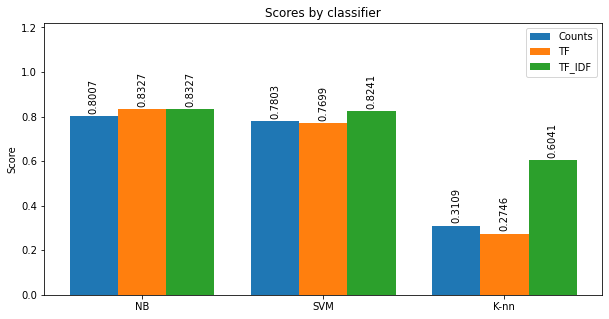

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_test_scores(results_per_transformer_per_classifier, TRANSFORMER_LABELS, ax)

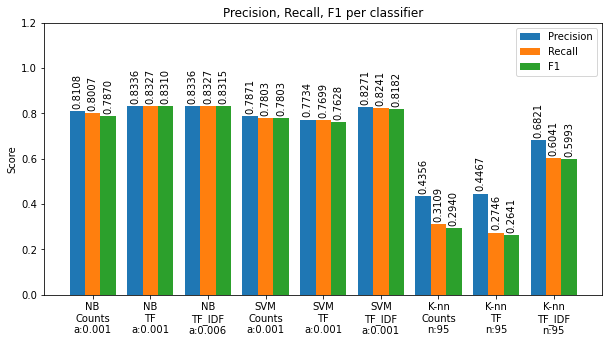

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_report(results, ax)

## Execute experiments for different Vectorizer types

In [13]:
best_results_of_classifiers = []
vectorizer_results_per_type_per_classifier = {}
vectorizer_results = []
for classifier_type in ClassifierType:
  print(classifier_type)
  classifier_results = list(filter(lambda c: c.config.classifier_name == classifier_type.value, results))
  best_results = max(classifier_results, key=lambda c: c.test_score)
  best_results_of_classifiers.append(best_results)
  for vectorizer_type in VectorizerType:
    config = pipeline_config_with_altered_vectorizer(best_results, vectorizer_type, classifier_type)
    if vectorizer_type.value not in vectorizer_results_per_type_per_classifier:
      vectorizer_results_per_type_per_classifier[vectorizer_type.value] = {}
    vect_results = get_results_for(config, X_train, y_train, X_test, y_test)
    vectorizer_results_per_type_per_classifier[vectorizer_type.value][classifier_type] = vect_results
    vectorizer_results.append(vect_results)

ClassifierType.NAIVE_BAYES
Executing pipeline for NB TF default
Best params: {}, test score: 0.8327137546468402
Executing pipeline for NB TF stop words
Best params: {}, test score: 0.831651619755709
Executing pipeline for NB TF non lowercase
Best params: {}, test score: 0.8315188528943176
Executing pipeline for NB TF word analyzer
Best params: {'vect__ngram_range': (1, 2)}, test score: 0.8349707912904939
Executing pipeline for NB TF char analyzer
Best params: {'vect__ngram_range': (5, 5)}, test score: 0.8250132766861391
Executing pipeline for NB TF max features
Best params: {'vect__max_features': 14000}, test score: 0.8178438661710037
ClassifierType.SGD
Executing pipeline for SVM TF_IDF default
Best params: {}, test score: 0.8240839086563994
Executing pipeline for SVM TF_IDF stop words
Best params: {}, test score: 0.822623473181094
Executing pipeline for SVM TF_IDF non lowercase
Best params: {}, test score: 0.8227562400424854
Executing pipeline for SVM TF_IDF word analyzer
Best params:

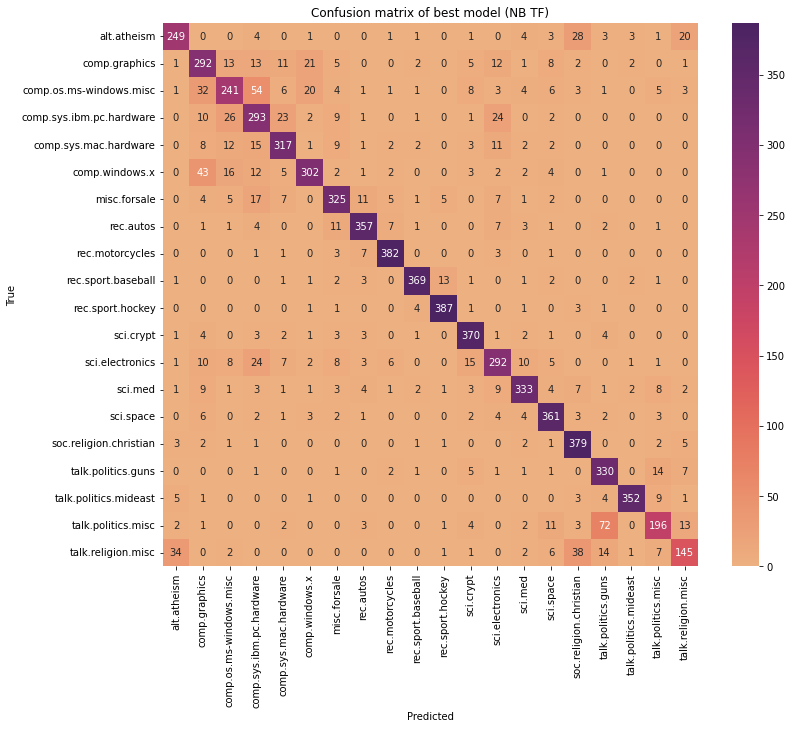

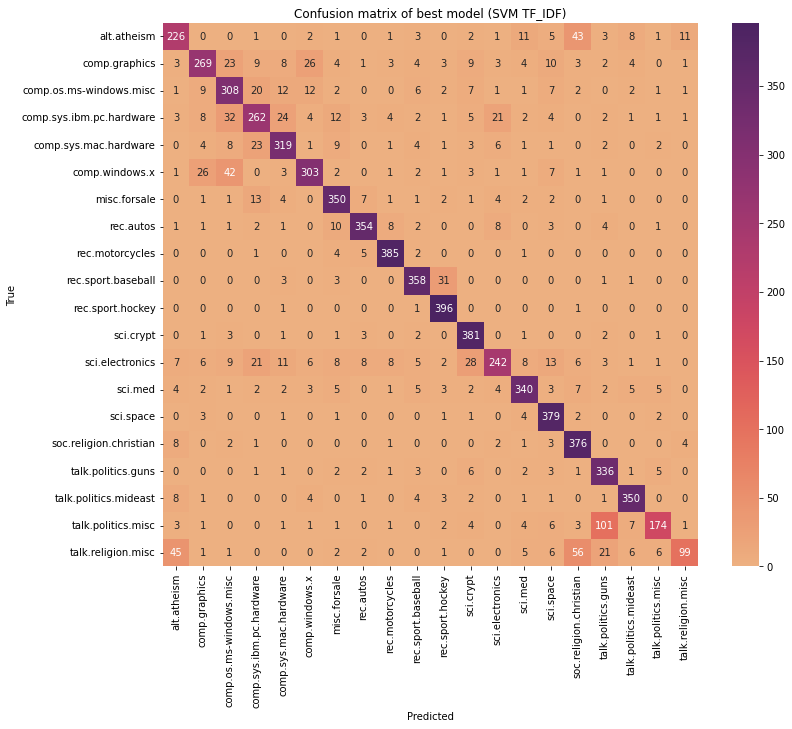

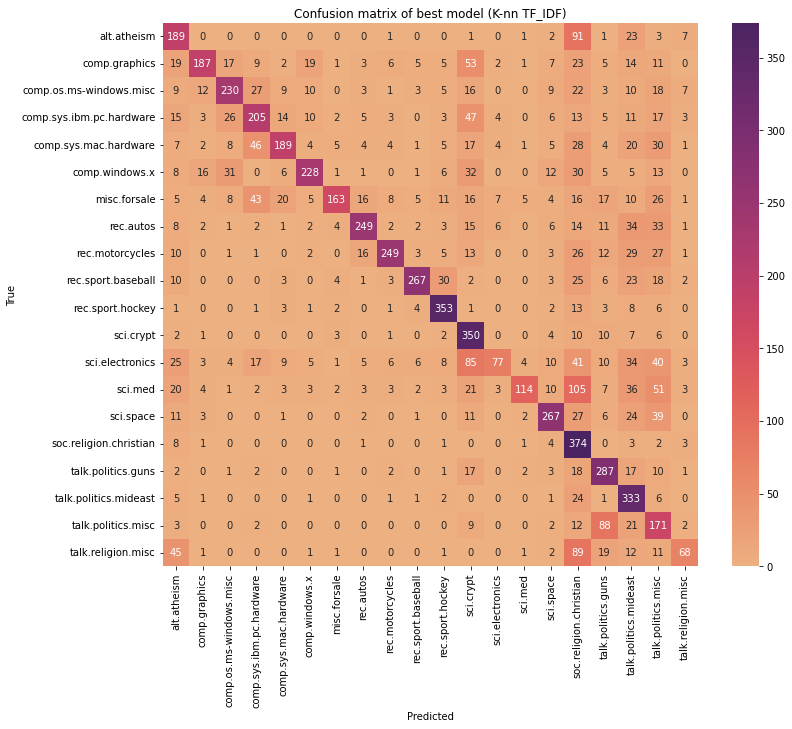

In [14]:
for best_results in best_results_of_classifiers:
  fig, ax = plt.subplots(figsize=(12, 10))
  plot_confusion_matrix(best_results, ax)

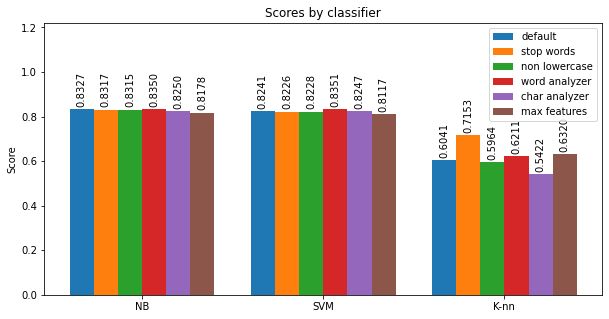

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_test_scores(vectorizer_results_per_type_per_classifier, VECTORIZER_LABELS, ax)

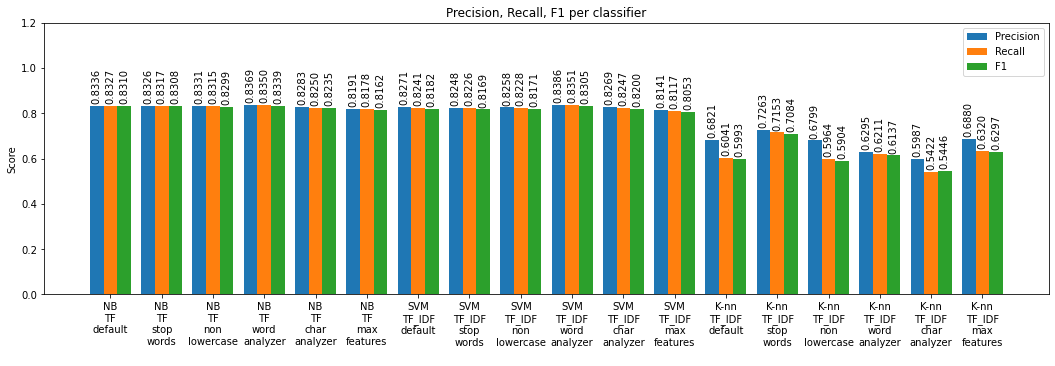

In [16]:
fig, ax = plt.subplots(figsize=(18, 5))
plot_report(vectorizer_results, ax)